# Consensus Income Classification Data Analysis

## Introduction

In the workforce, many factors can influence an individual’s salary. These can include (but are not limited to): level of education, occupation, age, sex, and race. Data from the U.S. Bureau of Labor Statistics found that men working in management earned more than their female counterparts, while people working in the service industry generally made the smallest salaries. In our project, we will design a classification model that will predict if an individual will make more than or less than $50,000, based on specific predictors. 

Would an 18 year old high school graduate working 40 hours per week have made more or less than $50,000 annually in 1994?

This dataset came from the UCI Machine Learning Repository and summarizes U.S. census data from 1994. It contains variables identifying age, work class, education, marital status, occupation, relationship, race, sex, capital gain and loss, hours per week, and native country. The variables influence whether an individual makes less than or more than \\$50,000. We will select specific variables to predict an individual’s categorical salary (less than or greater than \\$50,000).

In [1]:
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
library(ggplot2)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6) #displays maximum of 6 rows of dataframe

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
options(repr.plot.width = 8, repr.plot.height = 7)
set.seed(2022)
consensus_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", col_names = FALSE)
colnames(consensus_data) <- c("age", "workclass","fnlwgt","education","education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","income")
consensus_data <- mutate(consensus_data, income = as_factor(income))

#consensus_data
consensus_subset <- consensus_data |>
                    select(age, education_num, hours_per_week, income)
consensus_subset


Rows: 32561 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X2, X4, X6, X7, X8, X9, X10, X14, X15
dbl (6): X1, X3, X5, X11, X12, X13

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<fct>
39,13,40,<=50K
50,13,13,<=50K
38,9,40,<=50K
⋮,⋮,⋮,⋮
58,9,40,<=50K
22,9,20,<=50K
52,9,40,>50K


In [3]:
#Splitting data into 60% training and 40% testing sets
consensus_split <- initial_split(consensus_subset, prop = .60, strata = income)
consensus_training <- training(consensus_split) 
consensus_testing <- testing(consensus_split)
#consensus_training

In [4]:
# Summarizing number of observations per classification category
counts <- group_by(consensus_training, income) |>
          summarize(n = n())
counts

income,n
<fct>,<int>
<=50K,14832
>50K,4704


- to show that we could balance it—need to balance or not

In [5]:
#Means of the predictor variables that will be used within the analysis
predictor_averages <- consensus_training |>
                      select(-income)|>
                      summarize(across(age:hours_per_week, mean, na.rm = TRUE))
predictor_averages

age,education_num,hours_per_week
<dbl>,<dbl>,<dbl>
38.53378,10.09649,40.40018


- to better understand the data

*explanation on summary table

## Methods

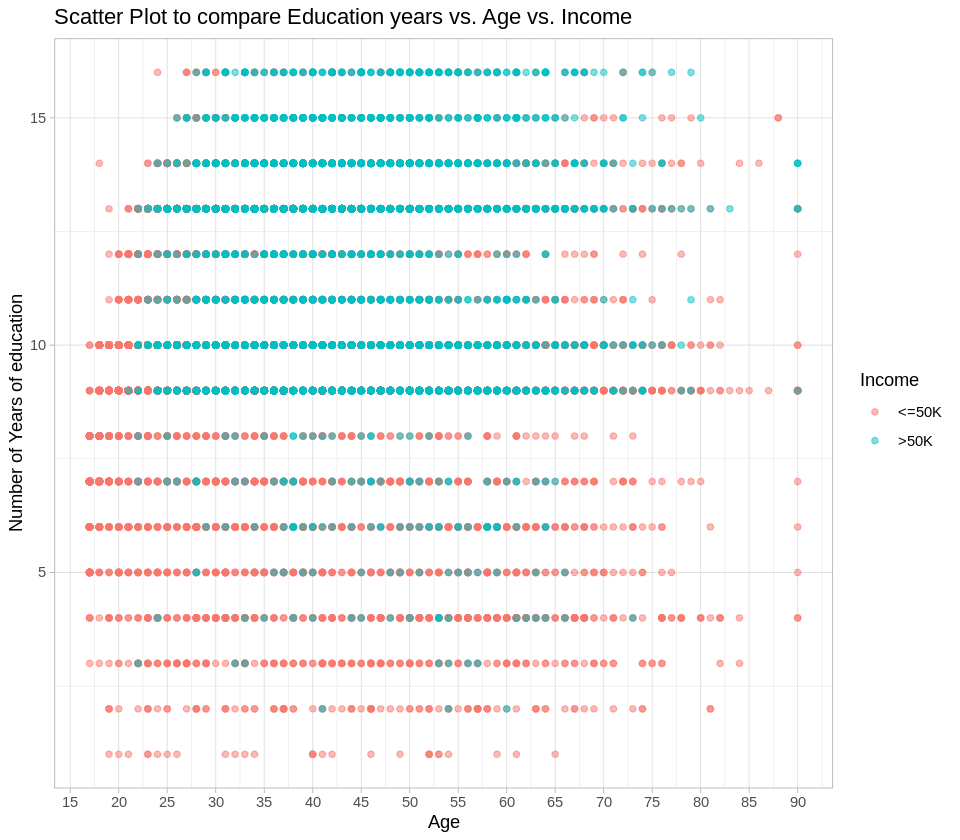

In [6]:
#scatter plots to compare every variable against income:
age_and_yrs_plot <- ggplot(data = consensus_training, aes(x = age, y = education_num)) +
                geom_point(aes(color = income), alpha = 0.5) +
                labs(x = "Age", y = "Number of Years of education", color = "Income") +
                ggtitle("Scatter Plot to compare Education years vs. Age vs. Income") +
                scale_x_continuous(breaks = seq(0, 100, by = 5)) +
                scale_y_continuous(breaks = seq(0, 20, by = 5)) +                
                theme_light()
age_and_yrs_plot

There seems to be a correlation between income and number or years of education. Seen in the graph The majority of people that have nine plus years of education make over \\$50,000 USD, which enables our hypothesis that as the number of education years increase it is more likely for an idividual to make more than \\$50,000. A correlation between age and income is somewhat present that the median of ages make over 50 grand.

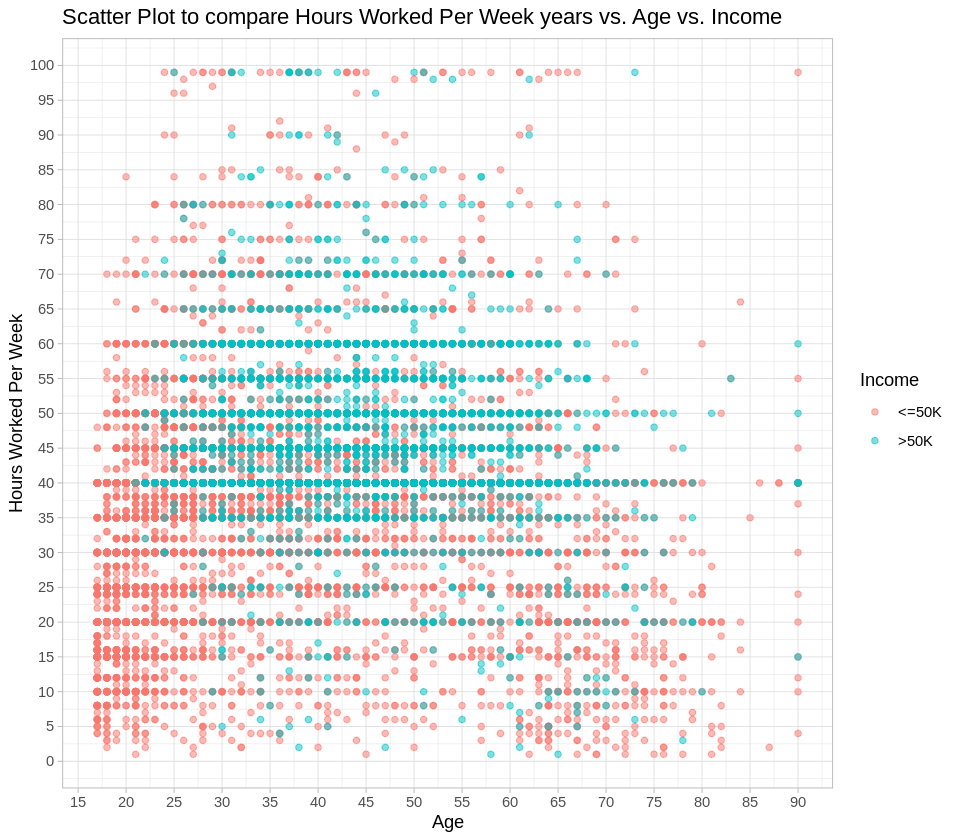

In [7]:
age_and_hrs_plot <- ggplot(data = consensus_training, aes(x = age, y = hours_per_week)) +
                geom_point(aes(color = income), alpha = 0.5) +
                labs(x = "Age", y = "Hours Worked Per Week", color = "Income") +
                ggtitle("Scatter Plot to compare Hours Worked Per Week years vs. Age vs. Income") +
                scale_x_continuous(breaks = seq(0, 100, by = 5)) +
                scale_y_continuous(breaks = seq(0, 100, by = 5)) +
                theme_light()
age_and_hrs_plot

The graph comparing hours worked per week indicate a relationship among the hours worked per week and annual income. As the majority of people who work 40 plus hours a week make greater than $50,000. From this visualization we can expect that generally someone who works more hours per week makes more money—possible the divider between greater than or less than 50 thousand.

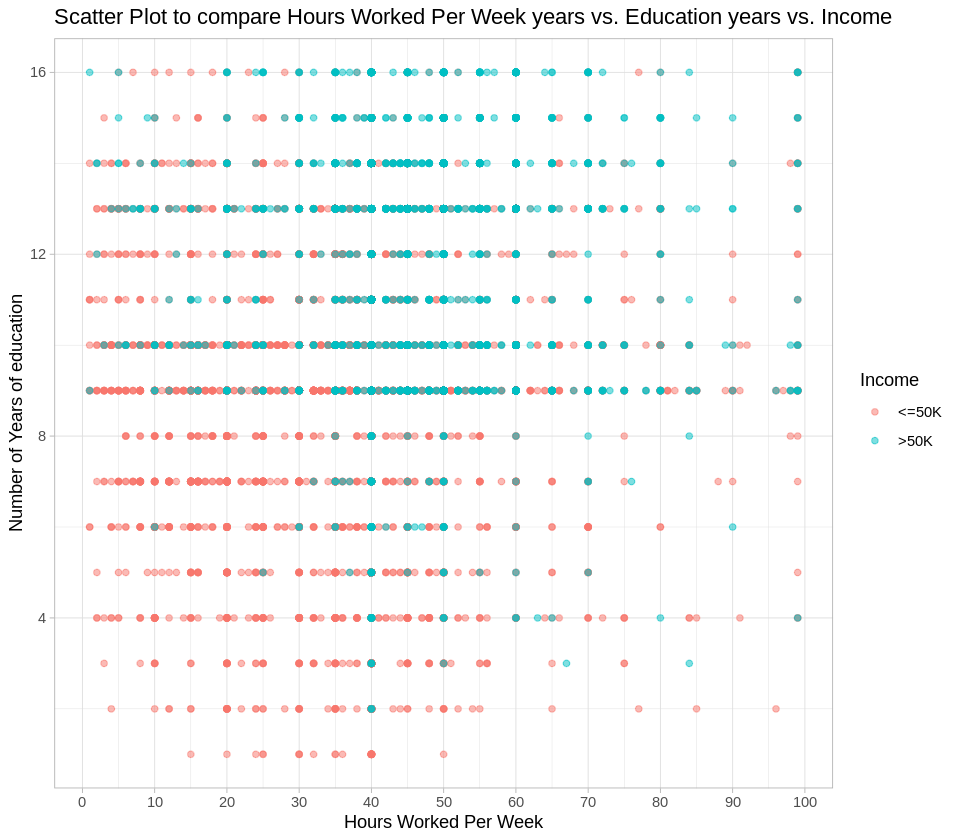

In [8]:
age_and_hrs_plot <- ggplot(data = consensus_training, aes(x = hours_per_week, y = education_num)) +
                geom_point(aes(color = income), alpha = 0.5) +
                labs(x = "Hours Worked Per Week", y = "Number of Years of education", color = "Income") +
                ggtitle("Scatter Plot to compare Hours Worked Per Week years vs. Education years vs. Income") +
                scale_x_continuous(breaks = seq(0, 120, by = 10)) +
                scale_y_continuous(limits = c(1, 16, by=4)) +
                theme_light()
age_and_hrs_plot

The graph which compares number of year of education and hours worked per week aligns with the prior visualizations that as both variables increase an indiviual is more likely to have an income above $50,000 USD in 1996.

In [9]:
#Scaling predictors
# income_recipe <- recipe(income ~ ., data = consensus_training) |>
#             step_scale(all_predictors()) |>
#             step_center(all_predictors()) |>
#             step_upsample(income, under_ratio = 1, skip = FALSE) |>
#             prep()
# income_recipe

income_recipe <- recipe(income ~ ., data = consensus_training) |>
            step_upsample(income, over_ratio = 1, skip = FALSE) |>
            prep()
income_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Training data contained 19536 data points and no missing data.

Operations:

Up-sampling based on income [trained]

In [10]:
scaled_income <- bake(income_recipe, consensus_training)
scaled_income
#Checking to see if classes are balanced after upsampling
upsampled_counts <- group_by(scaled_income, income) |>
                    summarize(n = n())
upsampled_counts

age,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<fct>
39,13,40,<=50K
50,13,13,<=50K
38,9,40,<=50K
⋮,⋮,⋮,⋮
33,9,50,>50K
52,12,55,>50K
29,11,40,>50K


income,n
<fct>,<int>
<=50K,14832
>50K,14832


We created a model specifiction 

In [11]:
income_recipe2 <- recipe(income ~ ., data = scaled_income) |>
             step_scale(all_predictors()) |>
             step_center(all_predictors())
income_recipe2

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [12]:
#Selecting K
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [13]:
#5 fold cross-validation
income_vfold <- vfold_cv(scaled_income, v = 5, strata = income)

In [14]:
#Making Workflow
k_vals <- tibble(neighbors = seq(from = 1, to = 21, by = 1))

knn_results <- workflow() |>
       add_recipe(income_recipe2) |>
       add_model(knn_tune) |>
       tune_grid(resamples = income_vfold, grid = k_vals) |>
       collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6464732,5,0.002288796,Preprocessor1_Model01
1,roc_auc,binary,0.6464732,5,0.002288796,Preprocessor1_Model01
2,accuracy,binary,0.6396297,5,0.003066144,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
20,roc_auc,binary,0.7713896,5,0.003381905,Preprocessor1_Model20
21,accuracy,binary,0.7155132,5,0.003759665,Preprocessor1_Model21
21,roc_auc,binary,0.7730998,5,0.003371694,Preprocessor1_Model21


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6464732,5,0.002288796,Preprocessor1_Model01
2,accuracy,binary,0.6396297,5,0.003066144,Preprocessor1_Model02
3,accuracy,binary,0.6664639,5,0.003501498,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
19,accuracy,binary,0.7144009,5,0.003214443,Preprocessor1_Model19
20,accuracy,binary,0.7138278,5,0.002848457,Preprocessor1_Model20
21,accuracy,binary,0.7155132,5,0.003759665,Preprocessor1_Model21


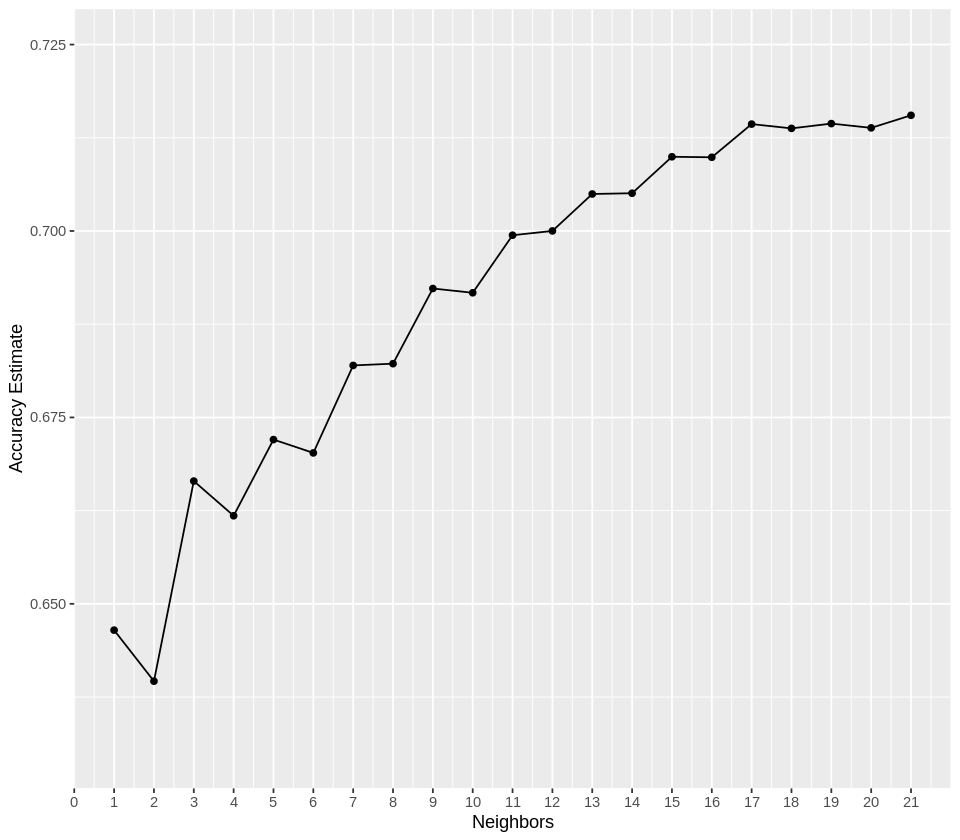

In [23]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy")
accuracies


accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") + 
       scale_x_continuous(breaks = seq(0, 21, by = 1)) +  # adjusting the x-axis
       #ylim(0.63,0.72)
       scale_y_continuous(limits = c(0.63,0.725)) # adjusting the y-axis
accuracy_versus_k

In [24]:
income_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
       set_engine("kknn") |>
       set_mode("classification")

income_fit <- workflow() |>
             add_recipe(income_recipe2) |>
             add_model(income_spec) |>
            fit(data = scaled_income)
income_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(17,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2722492
Best kernel: rectangular
Best k: 17

In [25]:
income_predictions <- predict(income_fit, consensus_testing) |>
                        bind_cols(consensus_testing)

income_metrics <- income_predictions |> 
                metrics(truth = income, estimate = .pred_class)

income_conf_mat <- income_predictions |>
                        conf_mat(truth = income, estimate = .pred_class) 
income_metrics
income_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7528599
kap,binary,0.3516047


          Truth
Prediction <=50K >50K
     <=50K  8084 1415
     >50K   1804 1722

In [18]:
new_obs <- tibble(age = 18, education_num = 12, hours_per_week = 40)
predict(income_fit, new_obs)

.pred_class
<fct>
<=50K
